In [1]:
import xarray as xr
import xclim

import cartopy.crs as ccrs
import climattr as eea
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
# define variables
mask_name = '/home/rafael/Downloads/amazonas.shp'
obs_dataset_path = '/media/rafael/Rafael/cmip6/jasmin/era5/amazon/era5_dataset.1981.2023.daily.t2m.nc'
all_dataset_path = '/media/rafael/Rafael/cmip6/jasmin/amazon/time/tasmax_day_IPSL-CM6A-LR_historical_*.nc'
nat_dataset_path = '/media/rafael/Rafael/cmip6/jasmin/amazon/time/tasmax_day_IPSL-CM6A-LR_hist-nat_*.nc' 

# Event Definition

This is often the hardest part of extreme event attribution. The event should be well observed in space and time. There is often tension between the impact (which are localised) and good signal to noise ratio and representation in climate models (large scale).

In general the aim is to define the event so that it is representative of a class of similar type events. These should be defined in terms of:
- The timescale associated with this class of event.
- The spatial scale associated with this class of event.

Remember if the definition is too specific then almost be definition the event you are looking at will be the most extreme. It may be useful to consider:

- Do you expect the model to simulate the extreme on exactly the same days as observed? (Most likely no). Would it have been less impactful if the event happened a week or month earlier/later than observed? Sometimes it can be useful to define the event in terms of say the maximum value over a month (or season), or the maximum 5-day period in a month.
- Would the event have been more/less impactful if it occurred in a slightly different region or covered a different area? i.e. we need to region considered to be large enough. Thinking about the nature of the impacts may be helpful with this. Often for high precipitation or flooding events this task is easier and the event region may be defined in terms of the catchment area of the river.

We can levarage the attribution package to filter the data in time and space. For example, if we can to analyze the maximum temperature in the Amazon during the summer (DJF) of 2015 we can use `eea.filter.filter_time` to filter the months (12, 1, 2), and select the time range. After that we can filter spatially using the attribution package with the `eea.filter.filter_area` function. In this case, we use as a mask to our dataset the shapefile of the Amazon state. We also add the argument `plot=True` so we can see a figure of our interest area. We could also use instead of a mask, a bounding box if not shapefile is available, for that we could set `box=[loni, lonf, lati, latf]` where the values represent the initial and final longitudes and latitudes to be selected. 

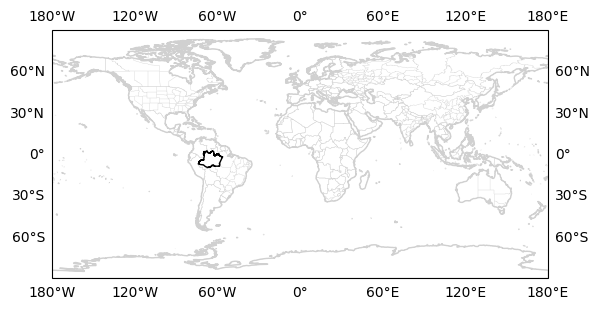

In [3]:
obs_dataset = xr.open_mfdataset(obs_dataset_path)

# filter time
obs_dataset = eea.filter.filter_time(obs_dataset, months=[12, 1, 2])

# filter area
obs_dataset = eea.filter.filter_area(obs_dataset[['t2m']], mask=mask_name, plot_area=True)

It is a good idea to check if the filter worked, so we make a plot to make sure of it.

<GeoAxes: title={'center': 'time = 1981-01-01'}>

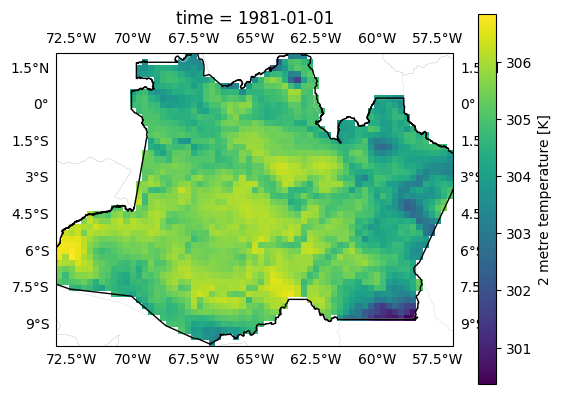

In [4]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# select the first time step
obs_dataset['t2m'].isel(time=0).plot(ax=ax)

eea.utils.add_features(ax, shapename=mask_name)

After that we can calculate an spatial average or maximum, for example, and calculate the index that we want to use to represent the extreme event. For example, we could represent a precipitation event that led to a flooding by a maximum one day precipitation, or an extreme heatwave event by a maximum of one day of maximum temperature, or use even longer timescales. We use the `eea.indice.xclim_indice` because of the `xclim` package in python that has most of those metrics already implemeneted. We are goin to use `tx_max` just as an example, but I encourage you look at their documentation to see if any other indice might be worth it [Xclim](https://xclim.readthedocs.io/en/stable/):

In [5]:
# calculate the area mean
obs_dataset_mean = obs_dataset.mean(dim=['longitude', 'latitude'], keep_attrs=True)

# calculate maximum one day temperature
obs_dataset_indice = eea.indice.xclim_indice(obs_dataset_mean, 'tx_max', tasmax='t2m', freq= 'YE-NOV')

# load data into memory
obs_dataset_indice = obs_dataset_indice.load()

After that we can do some exploratory analysis to evaluate how extreme the event was in the meteorological sense. For that we are going to use the `eea.exploratory.timeseries_plot` which plots the variable of interest highlighting the year we want to analyze (2015). Also, we can use the `eea.exploratory.rp_plot` to look for the recurrency of the event, and see how likely is this event in the meteorological series.

It is important to notice that we should use a fit function, which could be a GEV, Normal, Gamma, etc. to represent the data. This is specially important in extreme events because the results can change considerably from calculating the metrics based on couting the data in the tail of the distribution. For that we use the available fit functions from `scipy.stats` [Scipy](https://docs.scipy.org/doc/scipy/reference/stats.html).

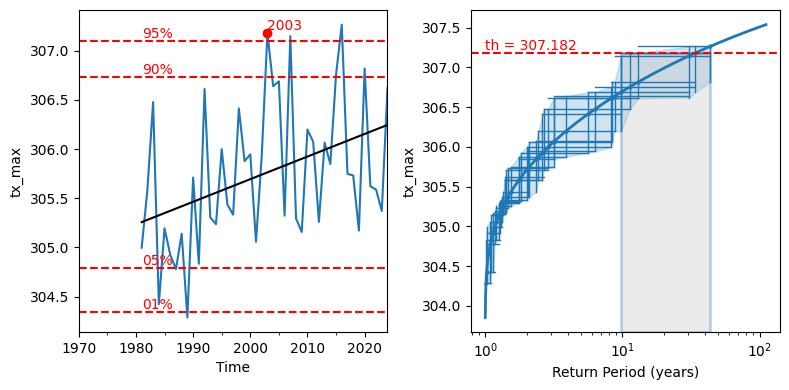

In [6]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.exploratory.timeseries_plot(ax1, obs_dataset_indice, highlight_year=2003)
eea.exploratory.rp_plot(ax2, obs_dataset_indice, scipy.stats.genextreme, highlight_year=2003)

ax1.set_xlabel('Time')
ax1.set_ylabel('tx_max')
ax2.set_xlabel('Return Period (years)')
ax2.set_ylabel('tx_max')

plt.tight_layout()

# Validating the model

It is important to check if the model is correctly representing the observations for the variable of interest. We can do that in many different ways, so we developed a few functions to help us do that. The first one is the `eea.validation.qq_plot_theoretical` which is a quantile-quantile plot (QQ plot) that compares the data with a theorical function, like GEV, or Normal that we can use to evaluate if the fit function that we selected is appropriate. If it is not we can try other functions from scipy.

For that we are first going to preprocess the data for the ALL simulation.

In [7]:
# ALL
all_dataset = eea.utils.multiens_netcdf(all_dataset_path, chunks={'time': 100})

all_dataset = eea.filter.filter_time(all_dataset, itime='1981-01-01', etime='2014-02-28', months=[12, 1, 2])
all_dataset = eea.filter.filter_area(all_dataset[['tasmax']], mask=mask_name, plot_area=False)

all_dataset_mean = all_dataset.mean(dim=['lon', 'lat'], keep_attrs=True)
all_dataset_indice = eea.indice.xclim_indice(all_dataset_mean[['tasmax']], 'tx_max', tasmax='tasmax', freq='YE-NOV')

# load data into memory
all_dataset_indice = all_dataset_indice.load()

Let's also check if the the spatial filter was sucessful.

<GeoAxes: title={'center': 'time = 1981-01-01T12:00:00, ensemble = r10i1p1f...'}>

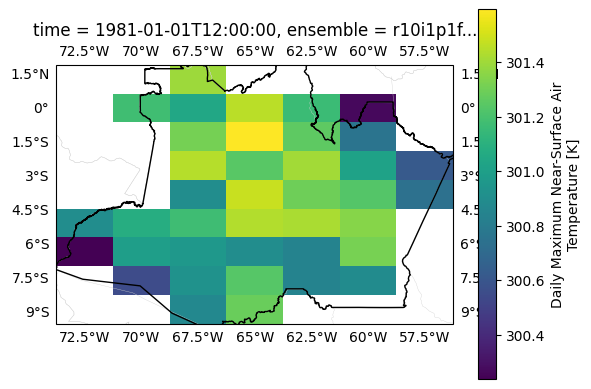

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# select the first time step
all_dataset['tasmax'].isel(time=0, ensemble=0).plot(ax=ax)

eea.utils.add_features(ax, shapename=mask_name)

We can also have a look at the timeseries and return period first to look if everything looks right, as we did with the observations.

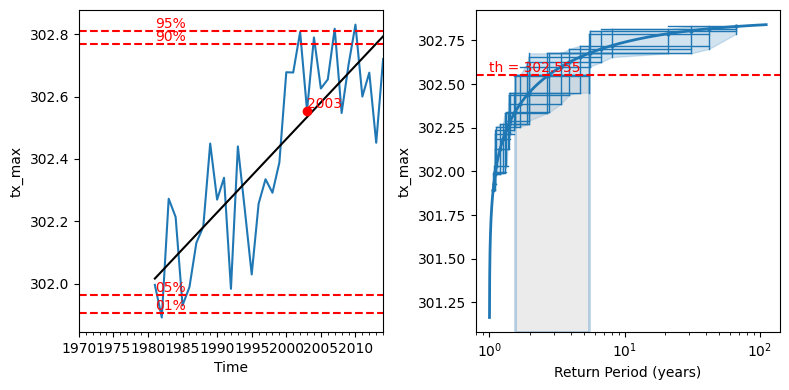

In [13]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.exploratory.timeseries_plot(ax1, all_dataset_indice.mean(dim='ensemble'), highlight_year=2003)
eea.exploratory.rp_plot(ax2, all_dataset_indice.mean(dim='ensemble'), scipy.stats.genextreme, highlight_year=2003)

ax1.set_xlabel('Time')
ax1.set_ylabel('tx_max')
ax2.set_xlabel('Return Period (years)')
ax2.set_ylabel('tx_max')

plt.tight_layout()

Now we are going to compare the quantiles from OBS and ALL with the theoretical quantiles from the GEV distribution. 

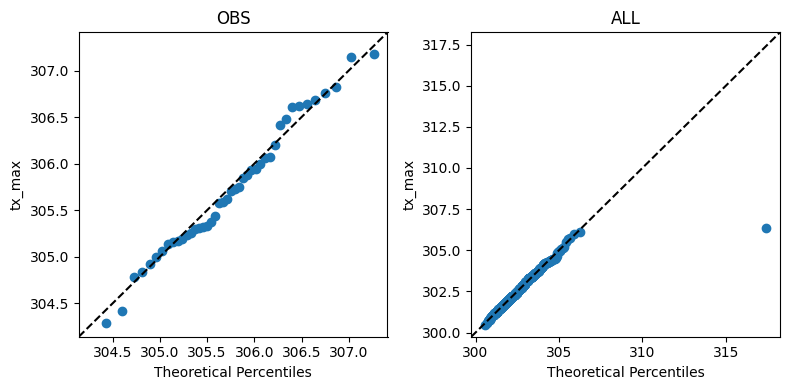

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.validation.qq_plot_theoretical(ax1, obs_dataset_indice, scipy.stats.genextreme)
eea.validation.qq_plot_theoretical(ax2, all_dataset_indice.dropna(dim='ensemble'), scipy.stats.genextreme)

ax1.set_title('OBS')
ax2.set_title('ALL')

ax1.set_xlabel('Theoretical Percentiles')
ax1.set_ylabel('tx_max')
ax2.set_xlabel('Theoretical Percentiles')
ax2.set_ylabel('tx_max')

plt.tight_layout()

The second one is `eea.validation.histogram_plot` which is the histogram validation plot that compares the distributions of the model and the observation. The other one is `eea.validation.qq_plot` which makes the QQ plot between the observation and model data so we can check how well the model performs.

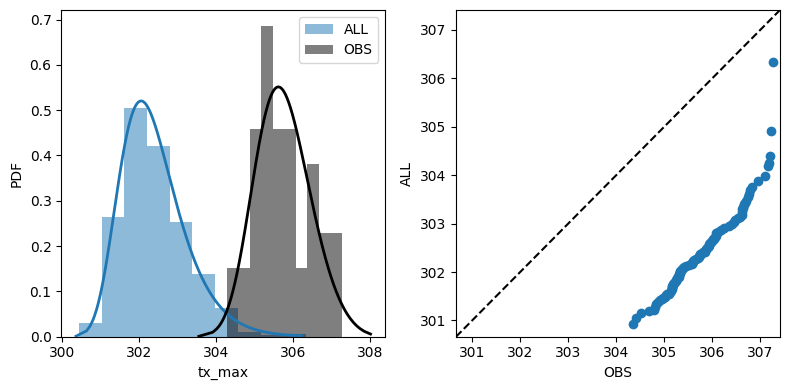

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.validation.histogram_plot(ax1, obs_dataset_indice, all_dataset_indice.dropna(dim='ensemble'), scipy.stats.genextreme)
eea.validation.qq_plot(ax2, obs_dataset_indice, all_dataset_indice.dropna(dim='ensemble'))

ax1.set_xlabel('tx_max')
ax1.set_ylabel('PDF')
ax2.set_xlabel('OBS')
ax2.set_ylabel('ALL')

plt.tight_layout()

We notice a systematic error in ALL compared with OBS of almost 4 °C. Therefore we scale the data based on the climatology using the `eea.correction.scaling` method. If the user selects the `method='add'` than it scales the data by subtracts the climatology from the dataset. If the method selected is `method='mult'` than divides the dataset by the climatology.

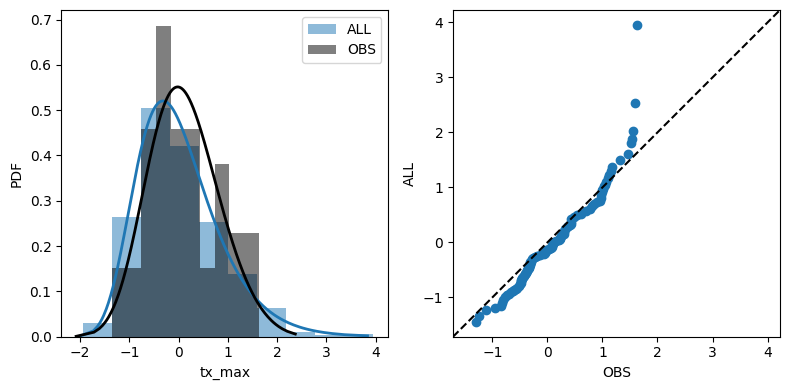

In [14]:
# scale the dataset and then plot the data again
all_dataset_indice_scaled = eea.correction.scaling(all_dataset_indice, all_dataset_indice, '1981-01-01', '2010-12-31', method='add')
obs_dataset_indice_scaled = eea.correction.scaling(obs_dataset_indice, obs_dataset_indice, '1981-01-01', '2010-12-31', method='add')

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.validation.histogram_plot(ax1, obs_dataset_indice_scaled, all_dataset_indice_scaled.dropna(dim='ensemble'), scipy.stats.genextreme)
eea.validation.qq_plot(ax2, obs_dataset_indice_scaled, all_dataset_indice_scaled.dropna(dim='ensemble'))

ax1.set_xlabel('tx_max')
ax1.set_ylabel('PDF')
ax2.set_xlabel('OBS')
ax2.set_ylabel('ALL')

plt.tight_layout()

# Attribution Analysis

For the attribution analysis, we are going to evaluate how the probabability of such an event or more extreme has changed from the natural scenario (NAT) and the all forcings scenario (ALL). For that, we are going to evaluate metrics like the Probability Ratio (PR), Fraction of Attributable Risk (FAR) and the Return Period (RP) of each scenario.

For that we are first going to preprocess the data for the NAT simulation.

In [15]:
# NAT
nat_dataset = eea.utils.multiens_netcdf(nat_dataset_path)
nat_dataset = eea.filter.filter_time(nat_dataset, itime='1981-01-01', etime='2014-02-28', months=[12, 1, 2])
nat_dataset = eea.filter.filter_area(nat_dataset[['tasmax']], mask=mask_name)

nat_dataset_mean = nat_dataset.mean(dim=['lon', 'lat'], keep_attrs=True)
nat_dataset_indice = eea.indice.xclim_indice(nat_dataset_mean, 'tx_max', tasmax='tasmax', freq='YE-NOV')

# load data into memory
nat_dataset_indice_scaled = eea.correction.scaling(nat_dataset_indice, all_dataset_indice, '1981-01-01', '2010-12-31', method='add')
nat_dataset_indice_scaled = nat_dataset_indice_scaled.load()

Notice that we scaled the NAT distribution using ALL climatology. After that we select ALL and NAT based on the period that we want to analyze for the attribution. Since we are using earth system models from CMIP6 that are not forced by the SST we don't expect that the model represents the same internal variability from the observations, which means that the event from 2003 will not necessarily happen exactly in 2003. Therefore we select a 10-year period around the event to represent the same warming rate that we see in the observations.

In [16]:
# load just the years that we want
all_dataset_indice_scaled_attr = eea.filter.filter_time(all_dataset_indice_scaled, itime='1998-01-01', etime='2008-12-31')
nat_dataset_indice_scaled_attr = eea.filter.filter_time(nat_dataset_indice_scaled, itime='1998-01-01', etime='2008-12-31')

We first plot the scaled that from the observation to get the threshold value for the attribution analysis.

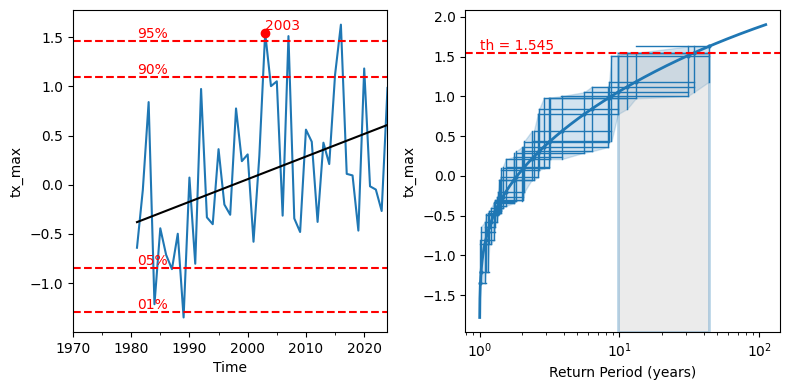

In [17]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.exploratory.timeseries_plot(ax1, obs_dataset_indice_scaled, highlight_year=2003)
eea.exploratory.rp_plot(ax2, obs_dataset_indice_scaled, scipy.stats.genextreme, highlight_year=2003)

ax1.set_xlabel('Time')
ax1.set_ylabel('tx_max')
ax2.set_xlabel('Return Period (years)')
ax2.set_ylabel('tx_max')

plt.tight_layout()

Now we are going to do the figures that help us visualize the changes from NAT and ALL. The `eea.attribution.histogram_plot` plots both histograms (NAT and ALL), with the threshold from the event so we can see how different the areas of the scenarios are, which means how much the probabilities of the events have changed. The second plot is the return period plot `eea.attribution.rp_plot` which shows the recurrency of the event in years, so we can evaluate how the recurrency of the event have changed from NAT to ALL, or look at a fixed RP to see how the magnitude of this type of event changed.

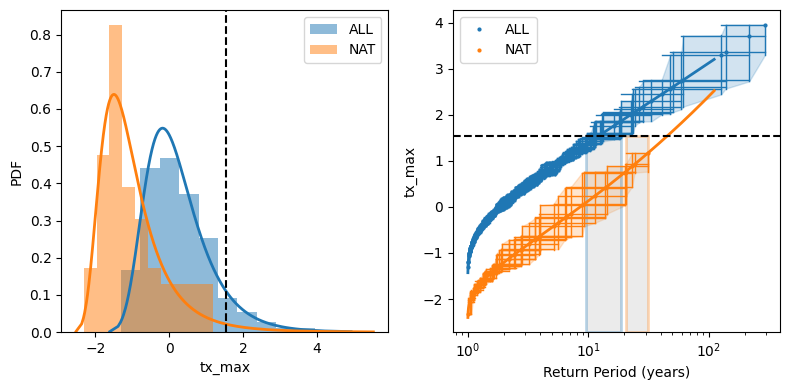

In [18]:
# plot histogram and RP plot to compare ALL and NAT
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.attribution.histogram_plot(ax1, all_dataset_indice_scaled_attr, nat_dataset_indice_scaled_attr, scipy.stats.genextreme, 1.545)
eea.attribution.rp_plot(ax2, all_dataset_indice_scaled_attr, nat_dataset_indice_scaled_attr, scipy.stats.genextreme, 1.545)

ax1.set_xlabel('tx_max')
ax1.set_ylabel('PDF')
ax2.set_xlabel('Return Period (years)')
ax2.set_ylabel('tx_max')

plt.tight_layout()

Now we are going to put some numbers into it! using the `eea.attribution.attribution_metrics` we can calculate PR and FAR with the confidence intervals calculate based bootstrap.

In [19]:
eea.attribution.attribution_metrics(all_dataset_indice_scaled_attr, nat_dataset_indice_scaled_attr, scipy.stats.genextreme, 1.545)

,value,ci_inf,ci_sup
PR,3.587683,1.546559,12.523043
FAR,0.721269,0.353403,0.920147
RP_ALL,12.329784,9.786324,16.801772
RP_NAT,44.492125,20.284847,142.587034
